<script>
    require(
    {
      // it makes sense to wait a little bit when you are loading
      // reveal from a cdn in a slow connection environment
      waitSeconds: 15
    },
    [
      "https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0/lib/js/head.min.js",
      "https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0/js/reveal.js"
    ],
    function(head, Reveal){
    setTimeout(function(){
    Reveal.configure({ width: "100%", height: "100%", center: false });
    }, 1000);
    });
</script>
# Working with Maps
## Extracting Features for Traffic Crash Insights



### Jenny Turner-Trauring


# Insight Lane
- Open source volunteer civic good project
- Builds tools to help cities and advocacy groups better understand crash risk
    - Machine learning model to predict risk given road features
    - Visualizes crash risk
    - Can be run on any city with crash data with geographic coordinates
- This talk focuses on how you can work with maps
    - I'll use Insight Lane's feature engineering pipeline as an example


# Libraries used in this talk

- Pandas
- Geopandas: Extends pandas to allow spatial operations
- Fiona: Reads and writes shapefiles
- Shapely: Performs operations on geometric shapes
- pyproj: python interface to PROJ cartographic conversion library
- Rtree: Tree data structure for fast spatial lookups
- QGIS: Open Source GIS application for working with geospatial data



# Slides
- The jupyter notebook for this slide deck, including code snippets is on my github

# Working with maps

- You might have one map for a single city
- You might have other geographical data, but you might not have a map
- You might want to combine geographical data from several data sources
- You might even want to add additional maps


For Insight Lane, we want any city to be able to use our tools, and so we use maps from OpenStreetMap as the base map

Then we add other geographic features

# OpenStreetMap (OSM)

OpenStreetMap is a free, open, crowdsourced map of the world

Lots of 3rd party services use OpenStreetMap for things such as:
- A base map
- Routing applications
- Looking at map features


# Central Square in Cambridge, Massachusetts
<br>
<table><tr><td><img src='osm_list.png'></td><td><img src='osm_central.png'></td></tr></table>


# OpenStreetMap Elements
- Nodes
    - Geographical points
- Ways
    - Ordered list of nodes
- Relations
    - E.g. administrative boundaries, turn restrictions
- Tags

# Getting data from OpenStreetMap
- [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) - read only API for accessing OpenStreetMap data
- Various python packages for using Overpass
- [osmnx](https://github.com/gboeing/osmnx) is a python package that allows users to easily download OpenStreetMap data 
    - Easily download street networks for specific cities
    - Can write resulting road network to shapefiles
    - [osmnx tutorial](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)


# Using osmnx to get a city's road network

In [295]:
# Just reset useful_tags_node in case the notebook is rerun
#ox.settings.useful_tags_node = ['ref', 'highway']

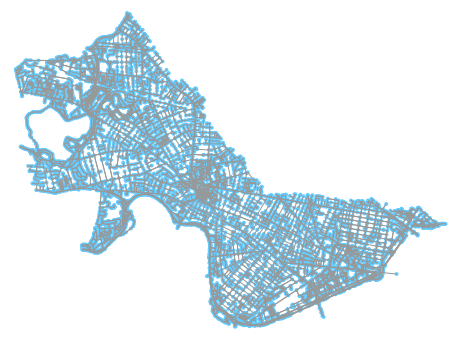

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [296]:
import osmnx as ox

G1 = ox.graph_from_place('Cambridge, Massachusetts, USA', simplify=False)
ox.plot_graph(G1)
print(type(G1))

# If there's no city boundary defined
- OpenStreetMap doesn't have administrative boundaries defined for all cities
- You can get data within a radius, or within a polygon
- Let's look at Central Square in Cambridge, Massachusetts

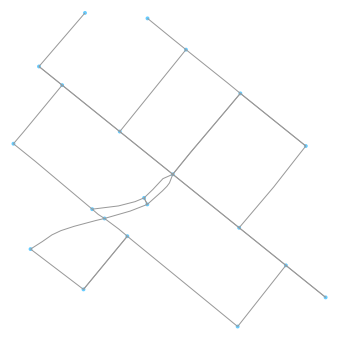

(<Figure size 582.028x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb45300a208>)

In [297]:
G2 = ox.graph_from_point((42.365572, -71.104034), distance=175, network_type='drive')
ox.plot_graph(G2)

# Unsimplified network
- graph_from_point simplifies the network by default, but you might want to look at the unsimplified network
- This still removes all nodes that aren't part of the road network

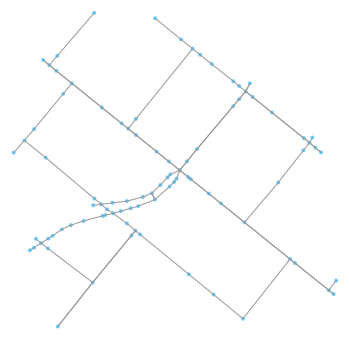

(<Figure size 601.216x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb452b6fe10>)

In [298]:
G3 = ox.graph_from_point((42.365572, -71.104034), distance=175, network_type='drive', simplify=False)
ox.plot_graph(G3)


# Tags
- OpenStreetMap uses tags to describe features of elements
- Tags consist of key value pairs
- Ways
    - name
    - oneway
    - cycleway (lane, track, etc)
    - maxspeed
    - width
- Nodes
    - highway (traffic_signals, stop sign, crosswalks)
    - amenity (postbox, cafe)

# Let's look at some nodes with highway tag
- Specifically traffic signals and stop signs
- Turn the MultiDiGraph returned by osmnx into a Pandas DataFrame
- Look at any node that has a highway tag with value 'traffic_signals' or 'stop'

In [299]:
import pandas
nodes, data = zip(*G1.nodes(data=True))
df_nodes = pandas.DataFrame(list(data), index=nodes)
osm_signals = df_nodes[df_nodes['highway'] == 'traffic_signals']
osm_stops = df_nodes[df_nodes['highway'] == 'stop']

print("{} traffic signals".format(osm_signals.shape[0]))
print("{} stop signs".format(osm_stops.shape[0]))

260 traffic signals
7 stop signs


# SEVEN stop signs??


- Road networks in OpenStreetMap generally are quite good
- Some other features are only as good as the crowdsourcing


Are the OSM traffic signals any good? <br> <br>
You can compare against Open Data from the City of Cambridge's municipal government

# Comparing OSM signals to municipal Open Data
- Download a shapefile from the city of Cambridge's Open Data portal
- Use geopandas to read in the shapefile


In [300]:
import geopandas
camb_signals = geopandas.read_file('TRAFFIC_Signals.shp')
print("{} traffic signals from Cambridge's Open Data Portal".format(camb_signals.shape[0]))
print("{} traffic signals from OpenStreetMap".format(osm_signals.shape[0]))


175 traffic signals from Cambridge's Open Data Portal
260 traffic signals from OpenStreetMap


We'll look into this in a bit

# So now we have OpenStreetMap network data
- We have ways (roads) and nodes (intersections)
- Depending on what you're doing, this might be enough
    - Intersections are higher risk
- For InsightLane, we need a different abstraction
    - OSM nodes provide few features
    - Crashes might not happen exactly at the intersection point
    - Doesn't handle complex intersections
- Look at roads feeding into the intersection
    - Based on Azavea's [algorithm](https://www.azavea.com/blog/2016/10/05/philippines-road-safety-using-shapely-fiona-locate-high-risk-traffic-areas/)


# Creating road segments: preprocessing

- You can turn osmnx output into a GeoPandas DataFrame
- Or you can write osmnx output to file
    - osmnx's save_graph_shapefile writes ways and nodes in ESRI shapefile format
    - Can also write to osm xml file or GraphML
    - We postprocess to GeoJSON format


#  Creating road segments: take GeoJSON map
- Roads are OpenStreetMap ways
- Intersection points are remaining nodes after osmnx simplification and dropping dead ends
<br>
<img src='elements_central.png' style="width: 70%;">

#  Creating road segments: buffer
- Create a 20 meter buffer around each intersection (Use shapely's buffer function)
- Merge overlapping buffers (Use shapely's unary_union function)
<img src='buffered_central.png'  style="width: 70%;">


#  Creating road segments: resulting intersection segments

<img src='inters_central.png' style="width: 70%;">


#  Creating road segments: resulting non-intersection segments
<img src='non_inters_central.png' style="width: 70%;">


# Creating road segments: results
<img src='inters_central.png' style="width: 40%; float:left">
<img src='non_inters_central.png' style="width: 40%; float:right">


# Working with multiple geographic datasets

- You need to have a framework against which to compare the datasets
    - Ours is the road segment abstraction
- Make sure the datasets have the same coordinate reference system (CRS)
- Visualize your data
    - It can be a good idea to make sure nothing weird is going on
    - It is useful to help debug weird data
    - If you're just trying to understand your data, it can be very helpful to look at a region you are familiar with

Our example is comparing the traffic signals from city of Cambridge's municipal data against the OpenStreetMap data

# Comparing data: projections

<img src='pumpkin2.jpg' style="width: 30%; float:right;"/>
<ul style="width: 60%;">
    <li>Maps are flat and the earth is spherical(ish)
    <li>Need a way to project the sphere onto a flat surface
    <li>A lot of data you'll encounter is in EPSG:4326
    <li>Typically store data in EPSG:4326 but display in EPSG:3857
    <li>But always check your dataset's coordinate reference system
</ul>

Useful reference [https://lyzidiamond.com/posts/4326-vs-3857](https://lyzidiamond.com/posts/4326-vs-3857)


# Comparing data: reprojecting using GeoPandas

In [312]:
def reproject(df, toproj):
    df_reprojected = df.copy()
    df_reprojected['geometry'] = df_reprojected['geometry'].to_crs(epsg=toproj)
    df_reprojected.crs = {'init' :'epsg:' + str(toproj)}
    return df_reprojected

camb_signals_3857 = reproject(camb_signals, 3857)
camb_signals_3857.head(1)

,ID,Location,Jurisdicti,Contact,geometry
0,1.0,Broadway & Third St.,City of Cambridge,TrafficEngineering@cambridgema.gov,POINT (-7913070.736672826 5215464.281262556)


#  Comparing data: reprojecting using pyproj

In [310]:
camb_signals.crs

{'init': 'epsg:2249'}

In [314]:
from pyproj import Transformer
transformer = Transformer.from_proj(2249, 3857, always_xy=True)
df_3857 = camb_signals.copy()
df_3857['geometry'] = df_3857.apply(lambda x: Point(transformer.transform(x['geometry'].x ,x['geometry'].y)), axis=1)

# Make sure that the results from GeoPandas reprojection and pyproj reprojection match
print(df_3857.equals(camb_signals_3857))

True


In [316]:
# Reproject OpenStreetMap data
from shapely.geometry import Point

def get_reproject_osm(df):
    # Turn the OpenStreetMap dataframe into a GeoDataFrame
    geometry = [Point(xy) for xy in zip(df.x, df.y)]
    df = df.drop(['y', 'x'], axis=1)
    crs = {'init': 'epsg:4326'}
    df = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    df = reproject(df, 3857)
    return df

osm_signals_3857 = get_reproject_osm(osm_signals)
osm_signals_3857.head(1)

,osmid,highway,geometry
387908358,387908358,traffic_signals,POINT (-7916969.181895554 5219304.204592618)


In [ ]:
# Output signals to geojson so we can visualize
# Reproject to epsg:4326 so the signals will match up with the road segments
camb_4326 = reproject(camb_signals_3857, 4326)
osm_4326 = reproject(osm_signals_3857, 4326)

camb_4326.to_file("camb_signals.geojson", driver='GeoJSON')
osm_4326.to_file("osm_signals.geojson", driver='GeoJSON')

#  Comparing reprojected data
<img src='signal_mismatch1.png' style="width: 40%; float:right;"/>
<ul style="width: 50%;">
    <li>Output to file
    <li>Visualize using QGIS GUI
    <li>Features in one dataset might be close but not identical to that in the other dataset
    <li>Standardize the two datasets: match up each signal with its closest road segment (intersection or non-intersection)
    <li>Insight Lane uses this technique to standardize point-based features
</ul>


# Standardization: match up nearby signals
- Use rtree for fast spatial lookups
    - Draw a circle around each point
    - Take all road segments that intersect the point
    - Choose nearest segment to the point

In [ ]:
import data.util
import fiona
import rtree

def read_segments(non_inters=True):
    # Read in and process intersection and non-intersection segments
    inter_df = reproject(geopandas.read_file('inters_segments.geojson'), 3857)

    inter = fiona.open('inters_segments.geojson')
    inter = data.util.reproject_records([x for x in inter]) 
    non_inter = fiona.open('non_inters_segments.geojson')
    non_inter = data.util.reproject_records([x for x in non_inter])

    #non_inter_df = reproject(geopandas.read_file('non_inters_segments.geojson'), 3857)
    #seg = pandas.concat([inter_df, non_inter_df])
    #display(inter_df.head())
    #display(non_inter_df.head())

    # Create rtree index for the segments - for fast spatial lookups
    segments_index = rtree.index.Index()
    segments = inter
    if non_inters:
        segments = segments + non_inter

    for idx, element in enumerate(segments):
        segments_index.insert(idx, element['geometry'].bounds)
    return segments, segments_index
        
def find_nearest(gdf, segments_dict, feature_name, buffer_size=20, key='ID'):
    near_ids = []
    for index, row in gdf.iterrows():
        row = row.to_dict()
        record_buffer_bounds = row['geometry'].buffer(buffer_size).bounds
        nearby_segments = segments_index.intersection(record_buffer_bounds)
        segment_id_with_distance = [
            # Get db index and distance to point
            (
                segments[segment_id]['properties']['id'],
                segments[segment_id]['geometry'].distance(row['geometry'])
            )
            for segment_id in nearby_segments
        ]
        if len(segment_id_with_distance):
            nearest = min(segment_id_with_distance, key=lambda tup: tup[1])
            if feature_name not in segments_dict[nearest[0]]['properties']:
                segments_dict[nearest[0]]['properties'][feature_name] = []
            segments_dict[nearest[0]]['properties'][feature_name].append(row[key])
            near_ids.append(nearest[0])
        else:
            near_ids.append(None)
    gdf = gdf.assign(near_id=near_ids)
    return gdf

segments, segments_index = read_segments()
segments_dict = {x['properties']['id']: x for x in segments}

# Standardization: find the nearest segments

In [ ]:
# You can find find_nearest in the jupyter notebook source for this presentation
camb = find_nearest(camb_signals_3857, segments_dict, 'camb_signals')
osm = find_nearest(osm_signals_3857, segments_dict, 'osm_signals', key='osmid')
display(camb.head(1))

# Comparing standardized data: look at leftover signals
- In this case, you can ignore multiple signals associated with a segment
- Also ignore matching signals

# Filter out signals unique to each dataset

In [ ]:
camb_only = camb[~camb['near_id'].isin(osm['near_id'])]
osm_only = osm[~osm['near_id'].isin(camb['near_id'])]

print("{} extra signals found in Cambridge Open Data".format(camb_only.shape[0]))
print("{} extra signals found in OpenStreetMaps".format(osm_only.shape[0]))

In [ ]:
# Output signals to geojson so we can visualize
# Reproject to epsg:4326 so the signals will match up with the road segments
camb_only_4326 = reproject(camb_only, 4326)
osm_only_4326 = reproject(osm_only, 4326)

camb_only_4326.to_file("camb_only.geojson", driver='GeoJSON')
osm_only_4326.to_file("osm_only.geojson", driver='GeoJSON')


# Mismatches

<img src='signal_mismatch2.png' style="width: 40%; float:right;"/>
<ul style="width: 50%;">
    <li>Output the mismatching datasets to file
    <li>Visualize in something like QGIS
    <li>OSM signals match to non-intersections on really big intersections
    <li>This accounts for many of the mismatches
</ul>


# Look at nearest intersection segment

In [ ]:
segments, segments_index = read_segments(non_inters=False)
segments_dict = {x['properties']['id']: x for x in segments}

camb = find_nearest(camb_signals_3857, segments_dict, 'camb_signals', buffer_size=20)
osm = find_nearest(osm_signals_3857, segments_dict, 'osm_signals', buffer_size=20, key='osmid')

camb_only = camb[~camb['near_id'].isin(osm['near_id'])]
osm_only = osm[~osm['near_id'].isin(camb['near_id'])]

print("{} extra signals found in Cambridge Open Data".format(camb_only.shape[0]))
print("{} extra signals found in OpenStreetMaps".format(osm_only.shape[0]))

# Mismatches

You can also visualize in OpenStreetMap directly

<img src='blinking.png'/>


# What have we learned?
- OpenStreetMap may not match city data
- You may be interested in updating OpenStreetMap for your city of interest
- Good idea to check your data to see if it makes sense


# Data limitations
- OpenStreetMap is internally consistent across cities, but can have incomplete data
- City data might have all sorts of differing formats or projections

# Interesting features
We can add any point-based data
- Traffic signals
- Vision Zero portal data
    - People filing traffic safety concerns
- See Click Fix or 311 data
- Parking tickets

We can also add features from other maps

In [ ]:
import data.util
results, _ = data.util.read_segments('/home/jenny/crash-model/data/cambridge/processed/maps')
foo = [x for x in results if x.properties['parking_tickets']]
len(results)

# Features from other maps

- Originally we used a Boston-specific map for this project
- That map included speed limit, width, AADT, type of road, and more
- How can we combine that map with OpenStreetMap?

# Maps don't always line up perfectly


<img src='map_overlay.png' style="width: 40%; float:left;"/>
<img src='google_map.png' style="width: 40%; float:right;">


# Combining maps

- Treat intersections and non-intersection segments differently
- Let's look at intersections first

<img src='map_overlay_with_line.png' style="width:40%">


# Combining intersections
- Create a buffer around the old intersection segment
<img src='map_overlay_with_1_buffer.png' style="width:60%">

# Combining intersections

- Create buffers around all the new intersection segments
- Look at all overlapping new buffers
- Take the one whose buffer has the greatest overlap


<img src='map_overlay_with_buffers.png' style="width:40%">

# Non-intersections

- Similar to intersections, but you might have two short segments one on map that correspond to a longer segment on the other map
- Because of the frequency of nearby parallel roads, we look for matches within an increasing buffer size

<img src='add_map_non_inters.png'>

# Now you can load and process map data
- Source code for this presentation will be linked at the end of the talk
- What's next?
    - Don't forget to think about equity
    - Insight Lane's crash model

# Equity
- We must think about how our work could contribute to inequity and how to avoid this


- Boston's Neighborhood Slow Streets Program
    - Traffic calming program on a neighborhood level
    - Application process includes letters of support from community groups
    - Evaluated based on "objective criteria"
        - Includes high crash areas, schools, children, seniors, but also proximity to transit

- Vision Zero portal data
    - Vision Zero concerns correlate with higher crash risk
    - But who is filing the concerns?

# Insight Lane's crash model

- We feed the features into a machine learning model to calculate crash risk
- Display the results in map form

<img src='insight_lane.png' style="width:80%">

# Contact
- jenineturner@gmail.com
- [https://github.com/j-t-t/presentations](https://github.com/j-t-t/presentations)

# Get involved!
- [https://insightlane.org](https://insightlane.org)
- [https://github.com/Data4Democracy/crash-model](https://github.com/Data4Democracy/crash-model)
